#Import des données

In [ ]:
#import du dataset avec une classe autre ajoutée
!pip install gdown

!gdown https://drive.google.com/uc?id=14RuGYw1FpuBB6MRgT7QX7e1JglmGVrp8
!unzip /content/plante_disease_dataset.zip 

In [ ]:
#import des poids des entrainements précédents

!gdown https://drive.google.com/uc?id=1BJi1LQ-sga1jx1-PS7dHCVzFg5iB310Z
!gdown https://drive.google.com/uc?id=1-7ApqQjvSmyioHiOdlFlRogqqaf4eZ_h

!unzip /content/model1.zip -d /content/model1
!unzip /content/model2.zip -d /content/model2

In [ ]:
#import des images de test
!gdown https://drive.google.com/uc?id=1-5sHUSGcB4TZp5QNnbk-hEM8tAQhMg_7
!unzip /content/testtext2.zip -d /content/test

In [1]:
#monter un google drive si besoin
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Test des gpu
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-88b9aacf-7c87-8ce5-f316-da4c754792a7)


In [53]:
#import des librairies

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay


# Générateur de données

In [56]:
batch_size = 64
n_class = 39

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,validation_split=0.02)

train_path = '/content/New Plant Diseases Dataset(Augmented)/train'
valid_path = '/content/New Plant Diseases Dataset(Augmented)/valid'
test_ext_path = '/content/drive/MyDrive/Projet_Plante/test_ext'

train_data = train_generator.flow_from_directory(directory=train_path,target_size=(224,224), batch_size=batch_size,shuffle=True)
valid_data = valid_generator.flow_from_directory(directory=valid_path,target_size=(224,224), batch_size=batch_size,subset='training',shuffle=False)
test_data = valid_generator.flow_from_directory(directory=valid_path,target_size=(224,224), batch_size=batch_size,subset='validation',shuffle=False)

test_data_ext =  train_generator.flow_from_directory(directory=test_ext_path,target_size=(224,224), batch_size=batch_size,shuffle=False)

Found 72326 images belonging to 39 classes.
Found 17631 images belonging to 39 classes.
Found 341 images belonging to 39 classes.
Found 10 images belonging to 1 classes.


# Entrainement du modèle 1 (Transfer learning Mobilenet) 

In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilenet = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")

mobilenet.trainable = False

model_1 = Sequential()
model_1.add(mobilenet)

model_1.add(Flatten())

model_1.add(Dense(units = 256,activation = 'relu'))
model_1.add(Dropout(rate = 0.2))
model_1.add(Dense(units = 128,activation = 'relu'))
model_1.add(Dense(units = n_class, activation = 'softmax'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model_1.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 39)                5031

In [ ]:
# Limitation exponentielle du learning rate apres la 1 epochs
def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

callback_sched_1 = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
#sauvegarde modele 1
callback_checkpoint_model_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/modele_1_checkpoint', monitor='val_acc', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq= 'epoch',
    options=None
)

In [ ]:
history_1 = model_1.fit(train_data, 
                                epochs = 15, 
                                validation_data = valid_data,
                                callbacks=[callback_checkpoint_model_1, callback_sched_1],
                                batch_size = batch_size,
                                )

Epoch 1/15
1131/1131 [==============================] - ETA: 0s - loss: 0.8753 - acc: 0.7698

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 221s 186ms/step - loss: 0.8753 - acc: 0.7698 - val_loss: 0.2891 - val_acc: 0.9117 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/15
1131/1131 [==============================] - ETA: 0s - loss: 0.3401 - acc: 0.8951

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 212s 188ms/step - loss: 0.3401 - acc: 0.8951 - val_loss: 0.2146 - val_acc: 0.9339 - lr: 8.1873e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/15
1131/1131 [==============================] - ETA: 0s - loss: 0.2236 - acc: 0.9302

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 213s 188ms/step - loss: 0.2236 - acc: 0.9302 - val_loss: 0.1722 - val_acc: 0.9484 - lr: 6.7032e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/15
1131/1131 [==============================] - ETA: 0s - loss: 0.1680 - acc: 0.9473

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 208s 184ms/step - loss: 0.1680 - acc: 0.9473 - val_loss: 0.1577 - val_acc: 0.9544 - lr: 5.4881e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 5/15
1131/1131 [==============================] - ETA: 0s - loss: 0.1252 - acc: 0.9598

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 208s 184ms/step - loss: 0.1252 - acc: 0.9598 - val_loss: 0.1464 - val_acc: 0.9597 - lr: 4.4933e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 6/15
1131/1131 [==============================] - 189s 167ms/step - loss: 0.0961 - acc: 0.9692 - val_loss: 0.1519 - val_acc: 0.9565 - lr: 3.6788e-04
Epoch 7/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0752 - acc: 0.9753

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 210s 186ms/step - loss: 0.0752 - acc: 0.9753 - val_loss: 0.1396 - val_acc: 0.9616 - lr: 3.0119e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 8/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0604 - acc: 0.9803

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 207s 183ms/step - loss: 0.0604 - acc: 0.9803 - val_loss: 0.1315 - val_acc: 0.9638 - lr: 2.4660e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 9/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0487 - acc: 0.9841

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 207s 183ms/step - loss: 0.0487 - acc: 0.9841 - val_loss: 0.1300 - val_acc: 0.9663 - lr: 2.0190e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 10/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0441 - acc: 0.9855

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 207s 183ms/step - loss: 0.0441 - acc: 0.9855 - val_loss: 0.1203 - val_acc: 0.9676 - lr: 1.6530e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 11/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0387 - acc: 0.9872

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 207s 183ms/step - loss: 0.0387 - acc: 0.9872 - val_loss: 0.1248 - val_acc: 0.9677 - lr: 1.3534e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 12/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0313 - acc: 0.9899

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 208s 184ms/step - loss: 0.0313 - acc: 0.9899 - val_loss: 0.1284 - val_acc: 0.9684 - lr: 1.1080e-04


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 13/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0284 - acc: 0.9910

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 207s 183ms/step - loss: 0.0284 - acc: 0.9910 - val_loss: 0.1204 - val_acc: 0.9686 - lr: 9.0718e-05


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 14/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0234 - acc: 0.9922

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 207s 183ms/step - loss: 0.0234 - acc: 0.9922 - val_loss: 0.1234 - val_acc: 0.9694 - lr: 7.4274e-05


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 15/15
1131/1131 [==============================] - ETA: 0s - loss: 0.0235 - acc: 0.9920

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 208s 184ms/step - loss: 0.0235 - acc: 0.9920 - val_loss: 0.1302 - val_acc: 0.9701 - lr: 6.0810e-05


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


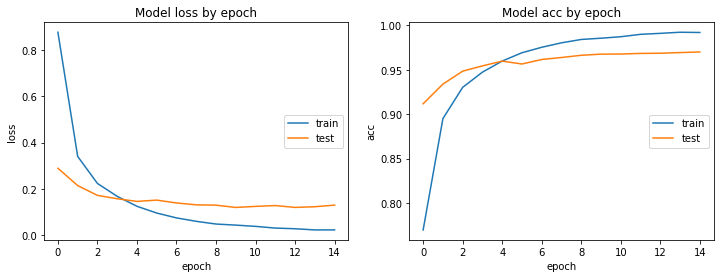

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
#fine tuning model1 
#chargement du checkpoint
model_1 = tensorflow.keras.models.load_model('/content/modele_1_checkpoint')

# Unfreeze the base model
for layer in base_model.layers[-4:]:
    mobilenet.trainable  = True

model_1.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['acc'])

history_1 = model_1.fit(train_data, 
                                epochs = 10, 
                                validation_data = valid_data,
                                callbacks=[callback_checkpoint_model_1, callback_sched_1],
                                batch_size = batch_size,
                                )

Epoch 1/10
1131/1131 [==============================] - ETA: 0s - loss: 0.0202 - acc: 0.9934

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 212s 185ms/step - loss: 0.0202 - acc: 0.9934 - val_loss: 0.1239 - val_acc: 0.9706 - lr: 1.0000e-05


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/10
1131/1131 [==============================] - ETA: 0s - loss: 0.0197 - acc: 0.9936

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 213s 188ms/step - loss: 0.0197 - acc: 0.9936 - val_loss: 0.1225 - val_acc: 0.9711 - lr: 8.1873e-06


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/10
1131/1131 [==============================] - ETA: 0s - loss: 0.0198 - acc: 0.9939

INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_1_checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1131/1131 [==============================] - 212s 188ms/step - loss: 0.0198 - acc: 0.9939 - val_loss: 0.1211 - val_acc: 0.9712 - lr: 6.7032e-06


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/10
1131/1131 [==============================] - 189s 167ms/step - loss: 0.0199 - acc: 0.9937 - val_loss: 0.1216 - val_acc: 0.9708 - lr: 5.4881e-06
Epoch 5/10
1131/1131 [==============================] - 189s 167ms/step - loss: 0.0198 - acc: 0.9939 - val_loss: 0.1218 - val_acc: 0.9712 - lr: 4.4933e-06
Epoch 6/10
1131/1131 [==============================] - 186s 165ms/step - loss: 0.0183 - acc: 0.9939 - val_loss: 0.1211 - val_acc: 0.9711 - lr: 3.6788e-06
Epoch 7/10
1131/1131 [==============================] - 186s 165ms/step - loss: 0.0186 - acc: 0.9941 - val_loss: 0.1204 - val_acc: 0.9708 - lr: 3.0119e-06
Epoch 8/10
1131/1131 [==============================] - 187s 165ms/step - loss: 0.0192 - acc: 0.9935 - val_loss: 0.1207 - val_acc: 0.9710 - lr: 2.4660e-06
Epoch 9/10
1131/1131 [==============================] - 187s 165ms/step - loss: 0.0194 - acc: 0.9941 - val_loss: 0.1210 - val_acc: 0.9708 - lr: 2.0190e-06
Epoch 10/10
1131/1131 [==============================] - 185s 164ms/st

# Entrainement du modèle 2 (Simple Convnet)

In [ ]:
model_2 = tf.keras.Sequential()

model_2.add(Conv2D(filters = 32,                   
                kernel_size = (3, 3),            
                input_shape = (224, 224, 3),     
                activation = 'relu'))            
model_2.add(MaxPooling2D(pool_size = (2, 2),))

model_2.add(Conv2D(filters = 64,                    
                kernel_size = (3, 3),
                activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2)))

model_2.add(Conv2D(filters = 128,                    
                kernel_size = (3, 3),
                activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2)))

model_2.add(Conv2D(filters = 128,                    
                kernel_size = (3, 3),
                activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2)))

model_2.add(Flatten())

model_2.add(Dense(units = 256, activation = 'relu'))
model_2.add(Dropout(rate = 0.8))
model_2.add(Dense(units = 128, activation = 'relu'))
model_2.add(Dense(units = n_class, activation = 'softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
# Limitation exponentielle du learning rate apres la 7 epochs
def scheduler(epoch, lr):
  if epoch < 7:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback_sched_1 = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
#sauvegarde modele 2
callback_checkpoint_model_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/modele_2_checkpoint', monitor='val_acc', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq= 'epoch',
    options=None
)

In [ ]:
history_2 = model_2.fit(train_data, 
                                epochs = 50, 
                                validation_data = valid_data,
                                callbacks=[callback_checkpoint_model_2, callback_sched_1],
                                batch_size = batch_size,
                                )

Epoch 1/50
1131/1131 [==============================] - ETA: 0s - loss: 2.7943 - acc: 0.2050INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 183s 160ms/step - loss: 2.7943 - acc: 0.2050 - val_loss: 1.6556 - val_acc: 0.4980 - lr: 0.0010
Epoch 2/50
1131/1131 [==============================] - ETA: 0s - loss: 1.7472 - acc: 0.4557INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 182s 161ms/step - loss: 1.7472 - acc: 0.4557 - val_loss: 0.9445 - val_acc: 0.7225 - lr: 0.0010
Epoch 3/50
1131/1131 [==============================] - ETA: 0s - loss: 1.2726 - acc: 0.5973INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 182s 161ms/step - loss: 1.2726 - acc: 0.5973 - val_loss: 0.6477 - val_acc: 0.8073 - lr: 0.0010
Epoch 4/50
1131/1131 [==============================] - ETA: 0s - loss: 1.0126 - acc: 0.6761INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 1.0126 - acc: 0.6761 - val_loss: 0.4960 - val_acc: 0.8432 - lr: 0.0010
Epoch 5/50
1131/1131 [==============================] - ETA: 0s - loss: 0.8549 - acc: 0.7260INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.8549 - acc: 0.7260 - val_loss: 0.4814 - val_acc: 0.8437 - lr: 0.0010
Epoch 6/50
1131/1131 [==============================] - ETA: 0s - loss: 0.7519 - acc: 0.7576INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 182s 161ms/step - loss: 0.7519 - acc: 0.7576 - val_loss: 0.3559 - val_acc: 0.8836 - lr: 0.0010
Epoch 7/50
1131/1131 [==============================] - ETA: 0s - loss: 0.6956 - acc: 0.7742INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 187s 165ms/step - loss: 0.6956 - acc: 0.7742 - val_loss: 0.3423 - val_acc: 0.8926 - lr: 0.0010
Epoch 8/50
1131/1131 [==============================] - 181s 160ms/step - loss: 0.5961 - acc: 0.8063 - val_loss: 0.3484 - val_acc: 0.8855 - lr: 9.0484e-04
Epoch 9/50
1131/1131 [==============================] - ETA: 0s - loss: 0.5397 - acc: 0.8235INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 183s 162ms/step - loss: 0.5397 - acc: 0.8235 - val_loss: 0.2710 - val_acc: 0.9140 - lr: 8.1873e-04
Epoch 10/50
1131/1131 [==============================] - ETA: 0s - loss: 0.4889 - acc: 0.8402INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 180s 160ms/step - loss: 0.4889 - acc: 0.8402 - val_loss: 0.2501 - val_acc: 0.9293 - lr: 7.4082e-04
Epoch 11/50
1131/1131 [==============================] - ETA: 0s - loss: 0.4306 - acc: 0.8586INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.4306 - acc: 0.8586 - val_loss: 0.1984 - val_acc: 0.9365 - lr: 6.7032e-04
Epoch 12/50
1131/1131 [==============================] - 180s 159ms/step - loss: 0.3980 - acc: 0.8678 - val_loss: 0.2216 - val_acc: 0.9297 - lr: 6.0653e-04
Epoch 13/50
1131/1131 [==============================] - ETA: 0s - loss: 0.3586 - acc: 0.8811INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 182s 161ms/step - loss: 0.3586 - acc: 0.8811 - val_loss: 0.1938 - val_acc: 0.9366 - lr: 5.4881e-04
Epoch 14/50
1131/1131 [==============================] - ETA: 0s - loss: 0.3329 - acc: 0.8898INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.3329 - acc: 0.8898 - val_loss: 0.1794 - val_acc: 0.9428 - lr: 4.9659e-04
Epoch 15/50
1131/1131 [==============================] - ETA: 0s - loss: 0.3096 - acc: 0.8982INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.3096 - acc: 0.8982 - val_loss: 0.1615 - val_acc: 0.9475 - lr: 4.4933e-04
Epoch 16/50
1131/1131 [==============================] - 179s 159ms/step - loss: 0.2859 - acc: 0.9047 - val_loss: 0.1701 - val_acc: 0.9455 - lr: 4.0657e-04
Epoch 17/50
1131/1131 [==============================] - ETA: 0s - loss: 0.2550 - acc: 0.9153INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.2550 - acc: 0.9153 - val_loss: 0.1475 - val_acc: 0.9538 - lr: 3.6788e-04
Epoch 18/50
1131/1131 [==============================] - ETA: 0s - loss: 0.2418 - acc: 0.9193INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.2418 - acc: 0.9193 - val_loss: 0.1446 - val_acc: 0.9556 - lr: 3.3287e-04
Epoch 19/50
1131/1131 [==============================] - ETA: 0s - loss: 0.2336 - acc: 0.9221INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.2336 - acc: 0.9221 - val_loss: 0.1426 - val_acc: 0.9575 - lr: 3.0119e-04
Epoch 20/50
1131/1131 [==============================] - 179s 158ms/step - loss: 0.2118 - acc: 0.9291 - val_loss: 0.1501 - val_acc: 0.9534 - lr: 2.7253e-04
Epoch 21/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1943 - acc: 0.9347INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1943 - acc: 0.9347 - val_loss: 0.1351 - val_acc: 0.9579 - lr: 2.4660e-04
Epoch 22/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1885 - acc: 0.9361INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1885 - acc: 0.9361 - val_loss: 0.1424 - val_acc: 0.9587 - lr: 2.2313e-04
Epoch 23/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1809 - acc: 0.9383INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1809 - acc: 0.9383 - val_loss: 0.1256 - val_acc: 0.9620 - lr: 2.0190e-04
Epoch 24/50
1131/1131 [==============================] - 180s 159ms/step - loss: 0.1702 - acc: 0.9419 - val_loss: 0.1328 - val_acc: 0.9604 - lr: 1.8268e-04
Epoch 25/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1647 - acc: 0.9453INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1647 - acc: 0.9453 - val_loss: 0.1325 - val_acc: 0.9621 - lr: 1.6530e-04
Epoch 26/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1563 - acc: 0.9472INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1563 - acc: 0.9472 - val_loss: 0.1221 - val_acc: 0.9641 - lr: 1.4957e-04
Epoch 27/50
1131/1131 [==============================] - 179s 158ms/step - loss: 0.1497 - acc: 0.9496 - val_loss: 0.1312 - val_acc: 0.9622 - lr: 1.3534e-04
Epoch 28/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1455 - acc: 0.9508INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1455 - acc: 0.9508 - val_loss: 0.1293 - val_acc: 0.9646 - lr: 1.2246e-04
Epoch 29/50
1131/1131 [==============================] - 179s 159ms/step - loss: 0.1401 - acc: 0.9528 - val_loss: 0.1255 - val_acc: 0.9645 - lr: 1.1080e-04
Epoch 30/50
1131/1131 [==============================] - 180s 159ms/step - loss: 0.1330 - acc: 0.9554 - val_loss: 0.1302 - val_acc: 0.9632 - lr: 1.0026e-04
Epoch 31/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1331 - acc: 0.9545INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1331 - acc: 0.9545 - val_loss: 0.1226 - val_acc: 0.9652 - lr: 9.0718e-05
Epoch 32/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1274 - acc: 0.9575INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 180s 159ms/step - loss: 0.1274 - acc: 0.9575 - val_loss: 0.1233 - val_acc: 0.9657 - lr: 8.2085e-05
Epoch 33/50
1131/1131 [==============================] - 179s 158ms/step - loss: 0.1246 - acc: 0.9585 - val_loss: 0.1299 - val_acc: 0.9637 - lr: 7.4273e-05
Epoch 34/50
1131/1131 [==============================] - 179s 158ms/step - loss: 0.1231 - acc: 0.9584 - val_loss: 0.1251 - val_acc: 0.9647 - lr: 6.7205e-05
Epoch 35/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1175 - acc: 0.9603INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1175 - acc: 0.9603 - val_loss: 0.1216 - val_acc: 0.9666 - lr: 6.0810e-05
Epoch 36/50
1131/1131 [==============================] - 179s 159ms/step - loss: 0.1171 - acc: 0.9603 - val_loss: 0.1269 - val_acc: 0.9649 - lr: 5.5023e-05
Epoch 37/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1171 - acc: 0.9600INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 180s 160ms/step - loss: 0.1171 - acc: 0.9600 - val_loss: 0.1221 - val_acc: 0.9668 - lr: 4.9787e-05
Epoch 38/50
1131/1131 [==============================] - ETA: 0s - loss: 0.1164 - acc: 0.9609INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


INFO:tensorflow:Assets written to: /content/modele_2_checkpoint/assets


1131/1131 [==============================] - 181s 160ms/step - loss: 0.1164 - acc: 0.9609 - val_loss: 0.1211 - val_acc: 0.9676 - lr: 4.5049e-05
Epoch 39/50
1131/1131 [==============================] - 179s 158ms/step - loss: 0.1128 - acc: 0.9618 - val_loss: 0.1231 - val_acc: 0.9662 - lr: 4.0762e-05
Epoch 40/50
1131/1131 [==============================] - 179s 158ms/step - loss: 0.1132 - acc: 0.9618 - val_loss: 0.1194 - val_acc: 0.9668 - lr: 3.6883e-05
Epoch 41/50
1131/1131 [==============================] - 180s 159ms/step - loss: 0.1068 - acc: 0.9642 - val_loss: 0.1211 - val_acc: 0.9671 - lr: 3.3373e-05
Epoch 42/50
1131/1131 [==============================] - 180s 159ms/step - loss: 0.1104 - acc: 0.9621 - val_loss: 0.1199 - val_acc: 0.9676 - lr: 3.0197e-05
Epoch 43/50
1131/1131 [==============================] - 180s 159ms/step - loss: 0.1061 - acc: 0.9639 - val_loss: 0.1201 - val_acc: 0.9673 - lr: 2.7324e-05
Epoch 44/50
1131/1131 [==============================] - 179s 159ms/step - l

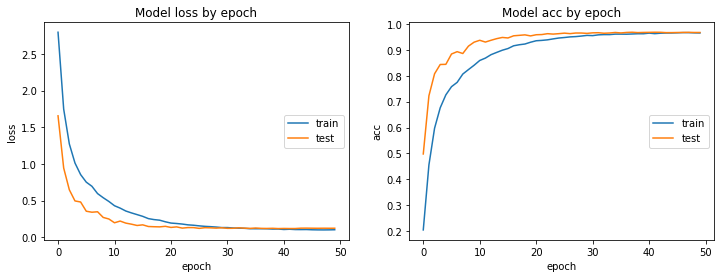

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
#Archivage des poids des modeles sur google drive

# import shutil

# shutil.make_archive('/content/model_1_v3', 'zip', '/content/modele_1_checkpoint')
# !cp /content/model_1_v3.zip /content/drive/MyDrive/Projet_Plante/

# shutil.make_archive('/content/model_2_v3', 'zip', '/content/modele_2_checkpoint')
# !cp /content/model_2_v3.zip /content/drive/MyDrive/Projet_Plante/


# Evaluation des modèles 

In [54]:
# Recharge des modèles
model_1 = tensorflow.keras.models.load_model('/content/model1')
model_2 = tensorflow.keras.models.load_model('/content/model2')

In [57]:
# Evaluation  modèle_1/mobilenet sur le jeu de test 
model_1.evaluate(test_data)

6/6 [==============================] - 9s 124ms/step - loss: 0.0527 - acc: 0.9853


[0.05268359184265137, 0.9853372573852539]

In [58]:
# Evaluation  modèle_2/convnet sur le jeu de test convnet
model_2.evaluate(test_data)

6/6 [==============================] - 1s 114ms/step - loss: 0.1527 - acc: 0.9619


[0.15274746716022491, 0.9618768095970154]

In [59]:
#predictions sur le jeu de test
y_probs_1 = model_1.predict(test_data)
y_preds_1 = tf.argmax(y_probs_1, axis=-1).numpy()

y_probs_2 = model_2.predict(test_data)
y_preds_2 = tf.argmax(y_probs_2, axis=-1).numpy()

In [ ]:
# pd.crosstab(y_preds_1,np.array(test_data.classes),rownames=["Prédiction"], colnames=["Réels"])

In [ ]:
# pd.crosstab(y_preds_2,np.array(test_data.classes),rownames=["Prédiction"], colnames=["Réels"])

In [ ]:
#Mobilenet
print(classification_report(np.array(test_data.classes),y_preds_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         9
           7       1.00      0.88      0.93         8
           8       1.00      1.00      1.00         9
           9       0.90      1.00      0.95         9
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00         9
          17       1.00    

In [ ]:
#Convenet
print(classification_report(np.array(test_data.classes),y_preds_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         8
           3       0.91      1.00      0.95        10
           4       1.00      1.00      1.00         9
           5       0.89      1.00      0.94         8
           6       0.90      1.00      0.95         9
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         9
          10       1.00      0.89      0.94         9
          11       0.90      1.00      0.95         9
          12       1.00      0.89      0.94         9
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00        10
          16       0.89      0.89      0.89         9
          17       1.00    

In [ ]:
#acceder à la position des images mal classees modele_1
mal_classe_1 = []
for i, j in enumerate(y_preds_1.tolist()):
    if test_data.classes[i] != j :
        mal_classe_1.append(i)

mal_classe_filename_1 = []
for i in mal_classe_1:
  mal_classe_filename_1.append(test_data.filepaths[i])


#acceder à la position des images mal classees modele_2
mal_classe_2 = []
for i, j in enumerate(y_preds_2.tolist()):
    if test_data.classes[i] != j :
        mal_classe_2.append(i)

mal_classe_filename_2 = []
for i in mal_classe_2:
  mal_classe_filename_2.append(test_data.filepaths[i])

Corn_(maize)___Northern_Leaf_Blight  /  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot

Tomato___Spider_mites Two-spotted_spider_mite  /  Tomato___Target_Spot

Tomato___Leaf_Mold  /  Tomato___Tomato_mosaic_virus

Tomato___healthy  /  Tomato___Tomato_mosaic_virus

Tomato___Target_Spot  /  Tomato___healthy



<Figure size 432x288 with 0 Axes>

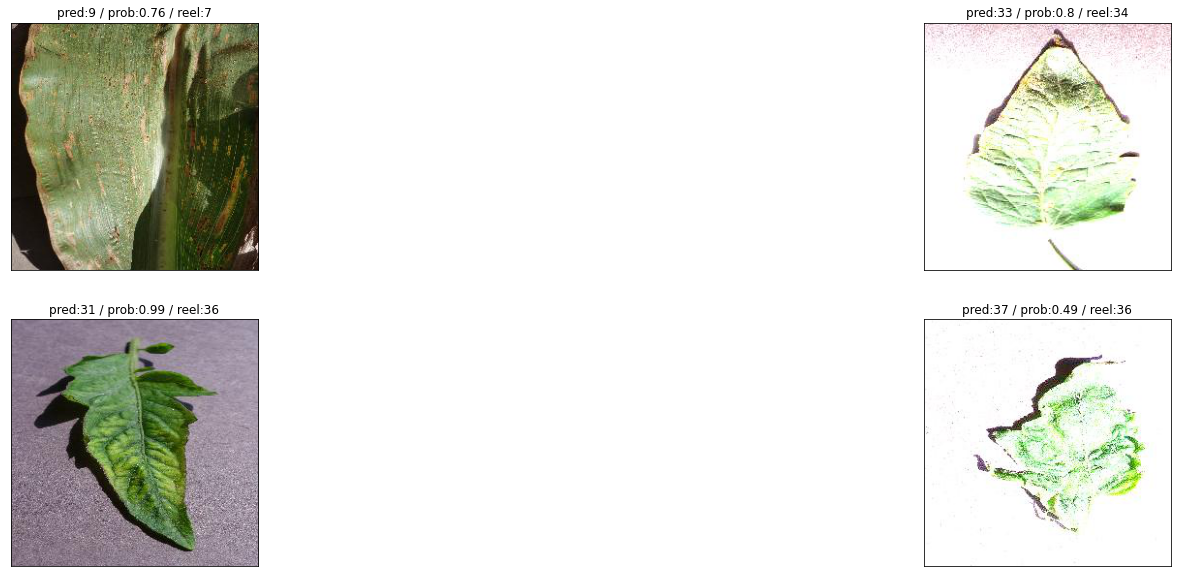

In [ ]:
#images mal classées modèle_1 mobilenet
plt.figure();

fig, ax = plt.subplots(2, int(len(mal_classe_filename_1)/2), subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    axi.set_title('pred:'+str(y_preds_1[mal_classe_1[i]])+' / prob:' + str(round(y_probs_1[mal_classe_1[i]].max(),2)) + ' / reel:' + str(test_data.classes[mal_classe_1[i]])) 
    img = plt.imread(mal_classe_filename_1[i])
    axi.imshow(img);


for i in mal_classe_1:
  classe_pred =  y_preds_1[i]
  classe_reel = test_data.classes[i]
  mydict = test_data.class_indices
  print(list(mydict.keys())[list(mydict.values()).index(classe_pred)],' / ', list(mydict.keys())[list(mydict.values()).index(classe_reel)])
  print()

Squash___Powdery_mildew  /  Corn_(maize)___healthy

Grape___Black_rot  /  Grape___Esca_(Black_Measles)

Cherry_(including_sour)___healthy  /  Peach___Bacterial_spot

Apple___healthy  /  Potato___Early_blight

Tomato___Late_blight  /  Tomato___Early_blight

Tomato___Leaf_Mold  /  Tomato___Early_blight

Tomato___Target_Spot  /  Tomato___Early_blight

Tomato___Target_Spot  /  Tomato___Late_blight

Cherry_(including_sour)___Powdery_mildew  /  Tomato___Late_blight

Tomato___Early_blight  /  Tomato___Late_blight

Peach___Bacterial_spot  /  Tomato___Septoria_leaf_spot

Tomato___Septoria_leaf_spot  /  Tomato___healthy

Tomato___Target_Spot  /  Tomato___healthy



<Figure size 432x288 with 0 Axes>

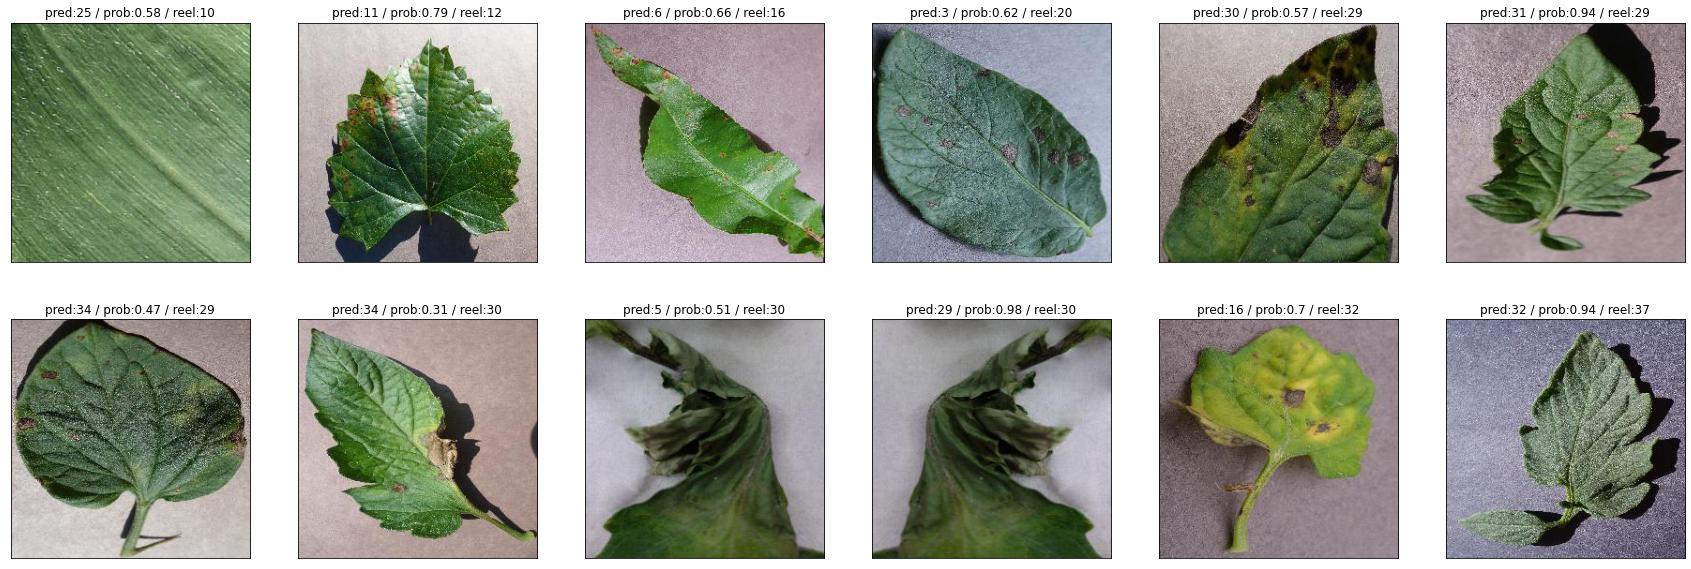

In [ ]:
#images mal classées modèle_2 convnet
plt.figure();

fig, ax = plt.subplots(2, int(len(mal_classe_2)/2), subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    axi.set_title('pred:'+str(y_preds_2[mal_classe_2[i]])+' / prob:' + str(round(y_probs_2[mal_classe_2[i]].max(),2)) + ' / reel:' + str(test_data.classes[mal_classe_2[i]])) 
    img = plt.imread(mal_classe_filename_2[i])
    axi.imshow(img);

for i in mal_classe_2:
  classe_pred =  y_preds_2[i]
  classe_reel = test_data.classes[i]
  mydict = test_data.class_indices
  print(list(mydict.keys())[list(mydict.values()).index(classe_pred)],' / ', list(mydict.keys())[list(mydict.values()).index(classe_reel)])
  print()

#Addition des 2 modèles

In [60]:
y_probs_tot = (0.6*y_probs_1 + 0.4*y_probs_2)
y_preds_tot = tf.argmax(y_probs_tot, axis=-1).numpy()
print(classification_report(np.array(test_data.classes),y_preds_tot))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00         9
          17       1.00    

In [61]:
#acceder à la position des images mal classees modele_tot
mal_classe_tot = []
for i, j in enumerate(y_preds_tot.tolist()):
    if test_data.classes[i] != j :
        mal_classe_tot.append(i)

mal_classe_filename_tot = []
for i in mal_classe_tot:
  mal_classe_filename_tot.append(test_data.filepaths[i])

Tomato___Spider_mites Two-spotted_spider_mite  /  Tomato___Target_Spot

Tomato___Leaf_Mold  /  Tomato___Tomato_mosaic_virus

Tomato___Target_Spot  /  Tomato___healthy



<Figure size 432x288 with 0 Axes>

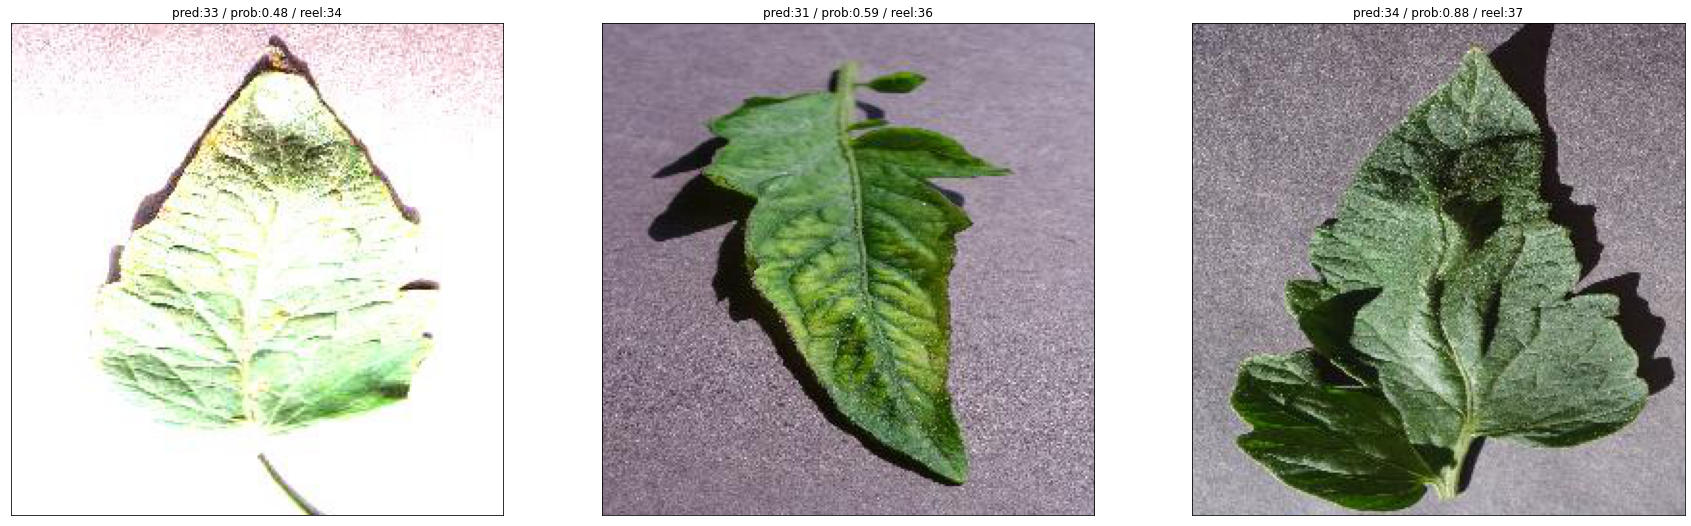

In [62]:
#images mal classées modèle_tot
plt.figure();

fig, ax = plt.subplots(1, len(mal_classe_filename_tot), subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    axi.set_title('pred:'+str(y_preds_tot[mal_classe_tot[i]])+' / prob:' + str(round(y_probs_tot[mal_classe_tot[i]].max(),2)) + ' / reel:' + str(test_data.classes[mal_classe_tot[i]])) 
    img = plt.imread(mal_classe_filename_tot[i])
    axi.imshow(img);


for i in mal_classe_tot:
  classe_pred =  y_preds_tot[i]
  classe_reel = test_data.classes[i]
  mydict = test_data.class_indices
  print(list(mydict.keys())[list(mydict.values()).index(classe_pred)],' / ', list(mydict.keys())[list(mydict.values()).index(classe_reel)])
  print()

#Test sur images exterieures

In [68]:
#Predictions
y_probs_ext_1 = model_1.predict(test_data_ext)
y_probs_ext_2 = model_2.predict(test_data_ext)
y_probs_ext_tot = 0.6*y_probs_ext_1 + 0.4*y_probs_ext_2
y_preds_ext = tf.argmax(y_probs_ext_tot, axis=-1).numpy()

<Figure size 432x288 with 0 Axes>

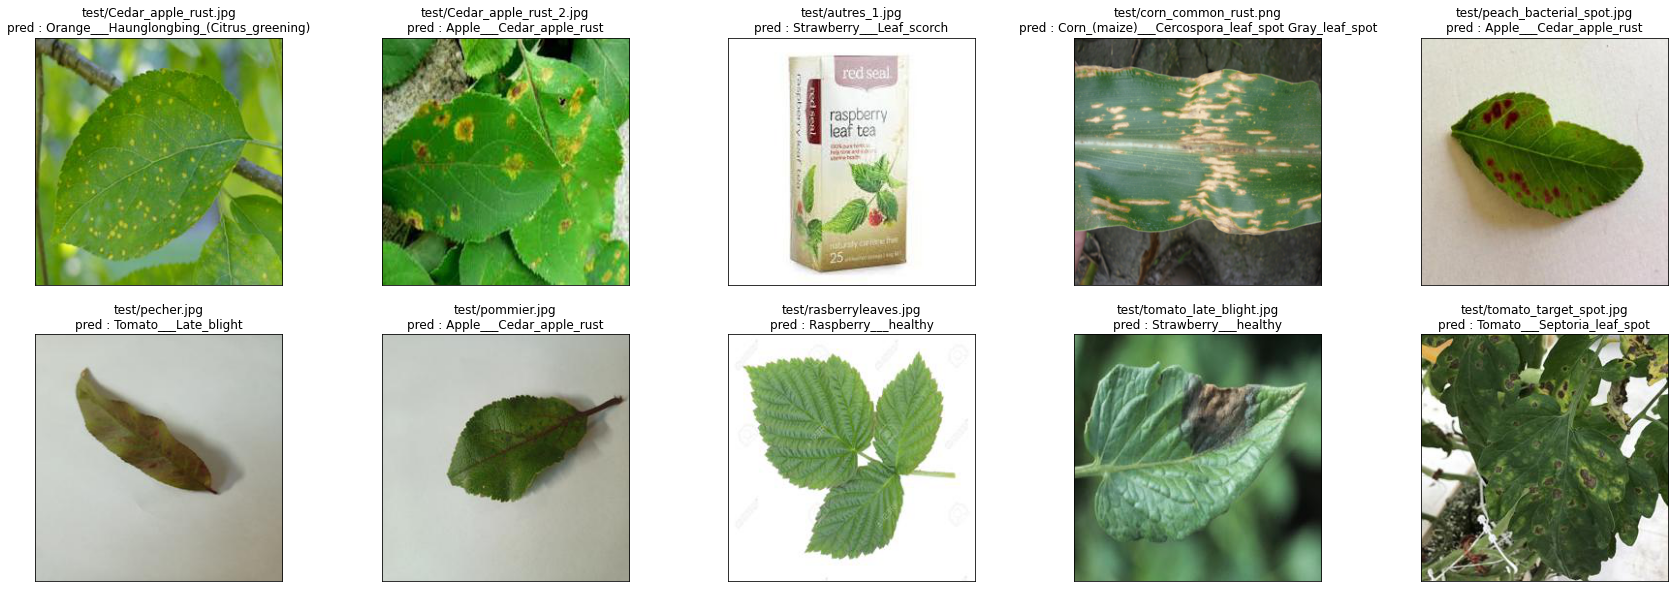

In [69]:
plt.figure();

fig, ax = plt.subplots(2, 5, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    axi.set_title(test_data_ext.filenames[i] + '\n' + 'pred : ' + list(mydict.keys())[list(mydict.values()).index(y_preds_ext[i])])
    img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(img);

#Visualisation cartes de caractéristiques

In [70]:
#création du tenseur d'activation à partir de l'image
img_path = mal_classe_filename_tot[2]

img = image.load_img(img_path,target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.
img_tensor.shape

(1, 224, 224, 3)

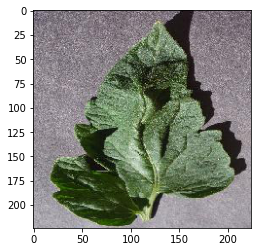

In [71]:
#affichage de l'image
plt.imshow(img_tensor[0])

In [72]:
#creation d'un modele qui predit les cartes d'activation à partir du tenseur
model = model_2
layer_output = [layer.output for layer in model.layers[:8]]
activation_model = tensorflow.keras.models.Model(inputs = model.input,
                                outputs = layer_output)

activations = activation_model.predict(img_tensor)



(1, 222, 222, 32)


<Figure size 432x288 with 0 Axes>

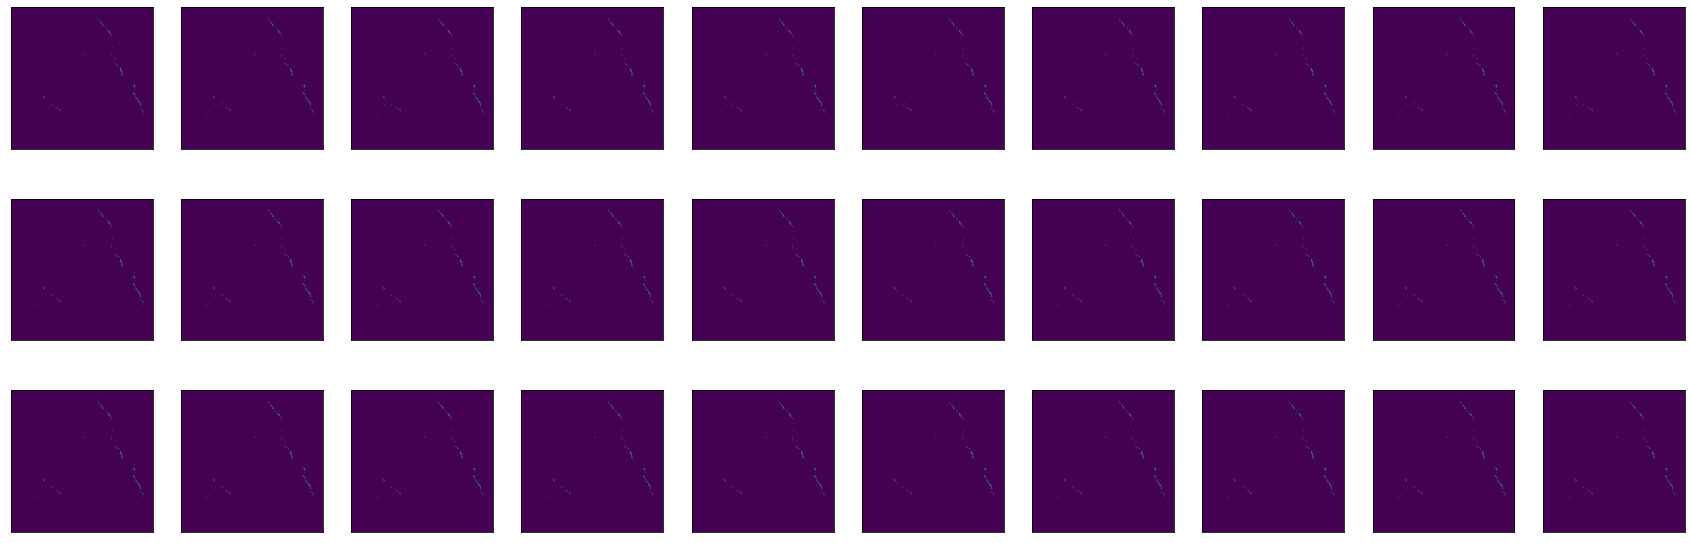

In [86]:
#features convolution1
first_layer_activation = activations[0]
print(first_layer_activation.shape)
# plt.matshow(first_layer_activation[0,:,:,31],cmap = 'viridis')


plt.figure();

fig, ax = plt.subplots(3, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    # axi.set_title()
    # img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(first_layer_activation[0,:,:,31],cmap = 'viridis');

(1, 111, 111, 32)


<Figure size 432x288 with 0 Axes>

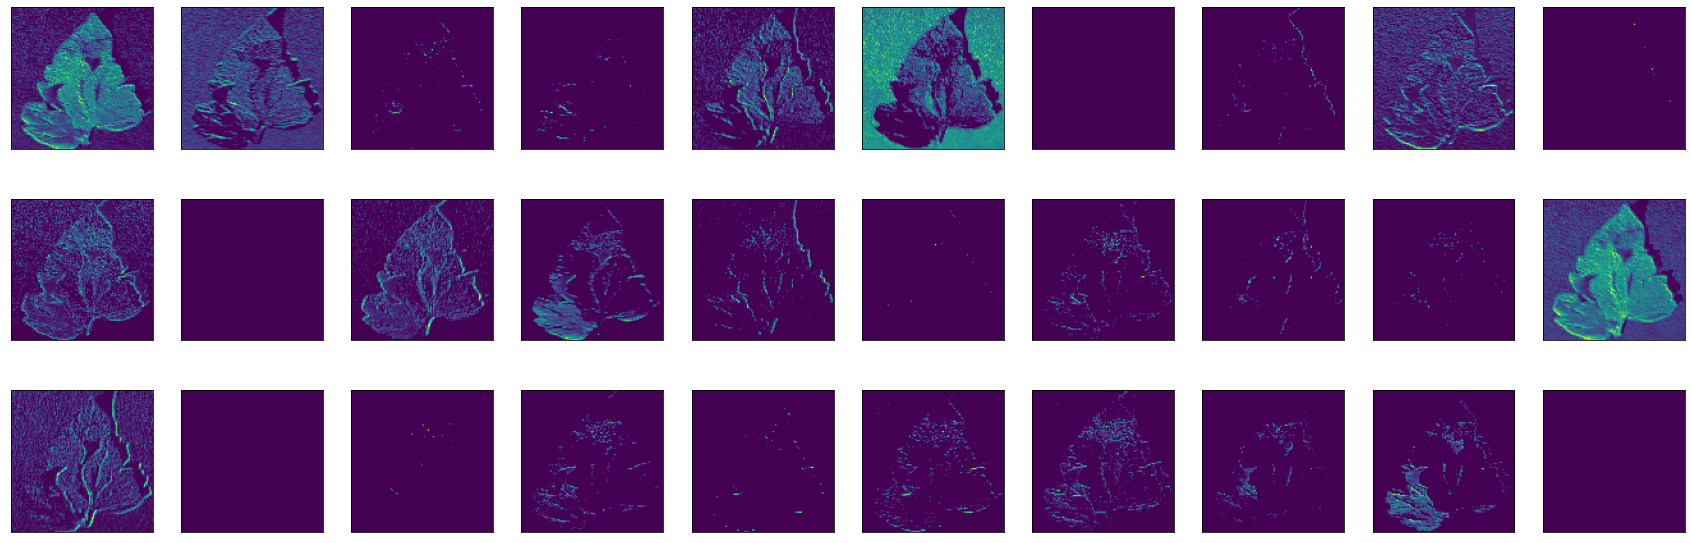

In [93]:
#features convolution2
first_layer_activation = activations[1]
print(first_layer_activation.shape)
# plt.matshow(first_layer_activation[0,:,:,31],cmap = 'viridis')


plt.figure();

fig, ax = plt.subplots(3, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    # axi.set_title()
    # img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(first_layer_activation[0,:,:,i],cmap = 'viridis');

(1, 109, 109, 64)


<Figure size 432x288 with 0 Axes>

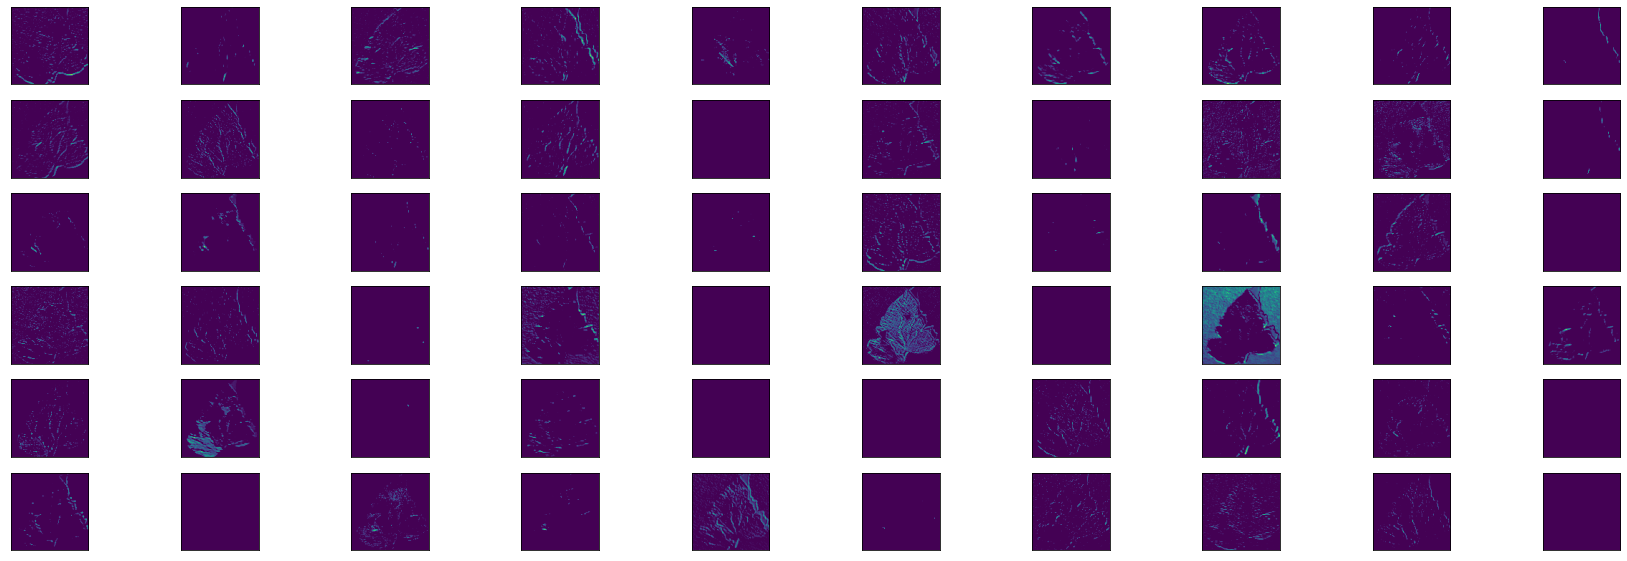

In [95]:
#features convolution3
first_layer_activation = activations[2]
print(first_layer_activation.shape)
# plt.matshow(first_layer_activation[0,:,:,31],cmap = 'viridis')


plt.figure();

fig, ax = plt.subplots(6, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    # axi.set_title()
    # img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(first_layer_activation[0,:,:,i],cmap = 'viridis');

(1, 54, 54, 64)


<Figure size 432x288 with 0 Axes>

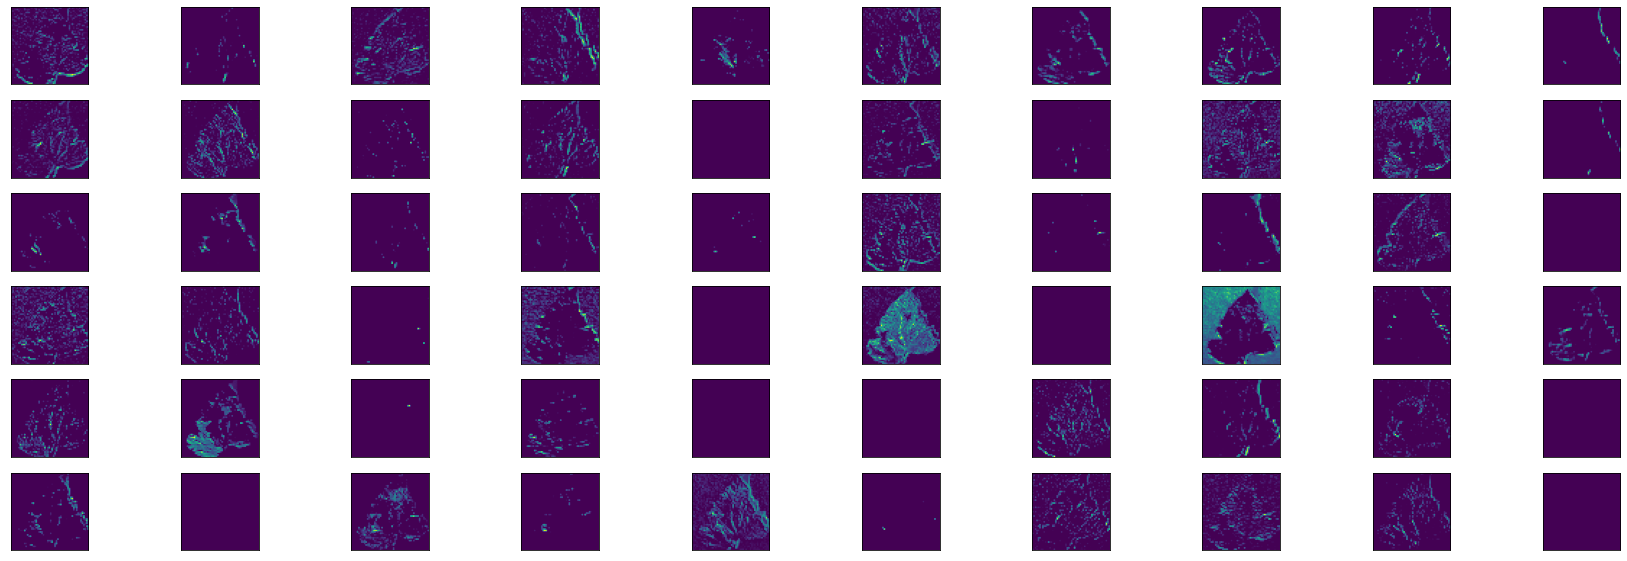

In [97]:
#features convolution4
first_layer_activation = activations[3]
print(first_layer_activation.shape)
# plt.matshow(first_layer_activation[0,:,:,31],cmap = 'viridis')


plt.figure();

fig, ax = plt.subplots(6, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    # axi.set_title()
    # img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(first_layer_activation[0,:,:,i],cmap = 'viridis');

(1, 52, 52, 128)


<Figure size 432x288 with 0 Axes>

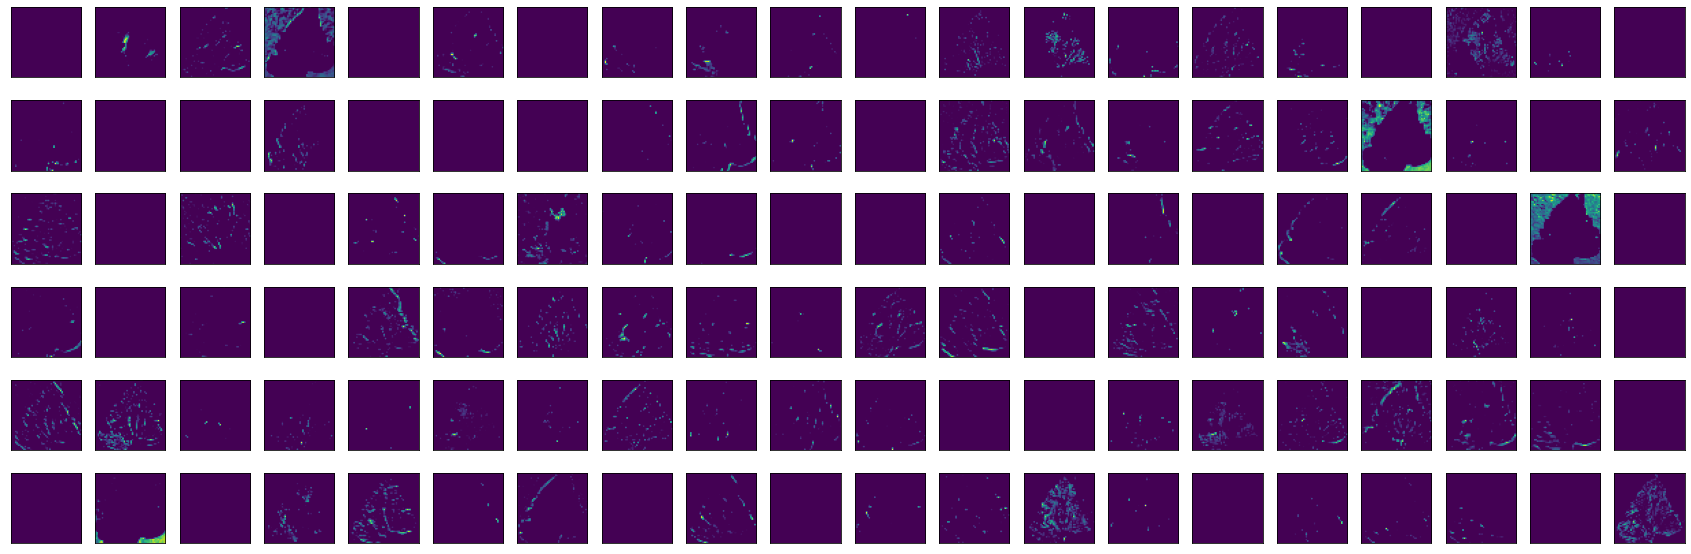

In [98]:
#features convolution5
first_layer_activation = activations[4]
print(first_layer_activation.shape)
# plt.matshow(first_layer_activation[0,:,:,31],cmap = 'viridis')


plt.figure();

fig, ax = plt.subplots(6, 20, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    # axi.set_title()
    # img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(first_layer_activation[0,:,:,i],cmap = 'viridis');

(1, 26, 26, 128)


<Figure size 432x288 with 0 Axes>

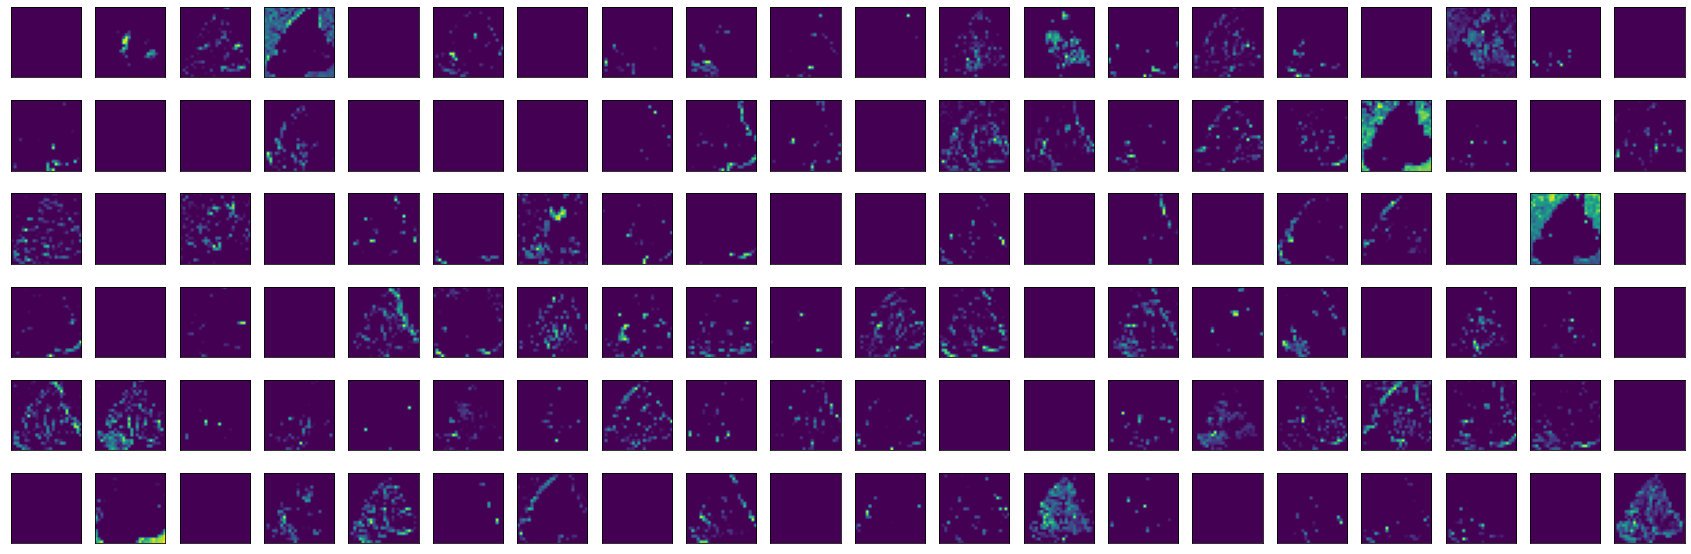

In [99]:
#features convolution6
first_layer_activation = activations[5]
print(first_layer_activation.shape)
# plt.matshow(first_layer_activation[0,:,:,31],cmap = 'viridis')


plt.figure();

fig, ax = plt.subplots(6, 20, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    # axi.set_title()
    # img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(first_layer_activation[0,:,:,i],cmap = 'viridis');

(1, 24, 24, 128)


<Figure size 432x288 with 0 Axes>

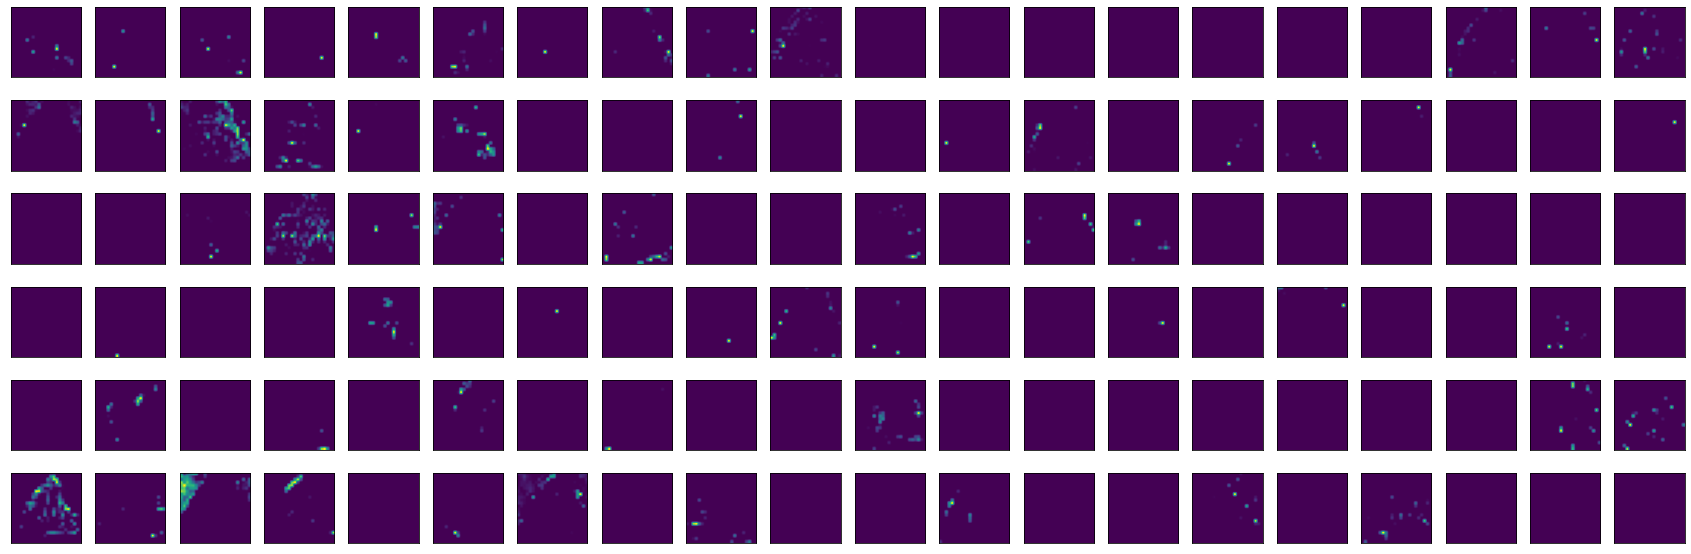

In [100]:
#features convolution7
first_layer_activation = activations[6]
print(first_layer_activation.shape)
# plt.matshow(first_layer_activation[0,:,:,31],cmap = 'viridis')


plt.figure();

fig, ax = plt.subplots(6, 20, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    # axi.set_title()
    # img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(first_layer_activation[0,:,:,i],cmap = 'viridis');

(1, 12, 12, 128)


<Figure size 432x288 with 0 Axes>

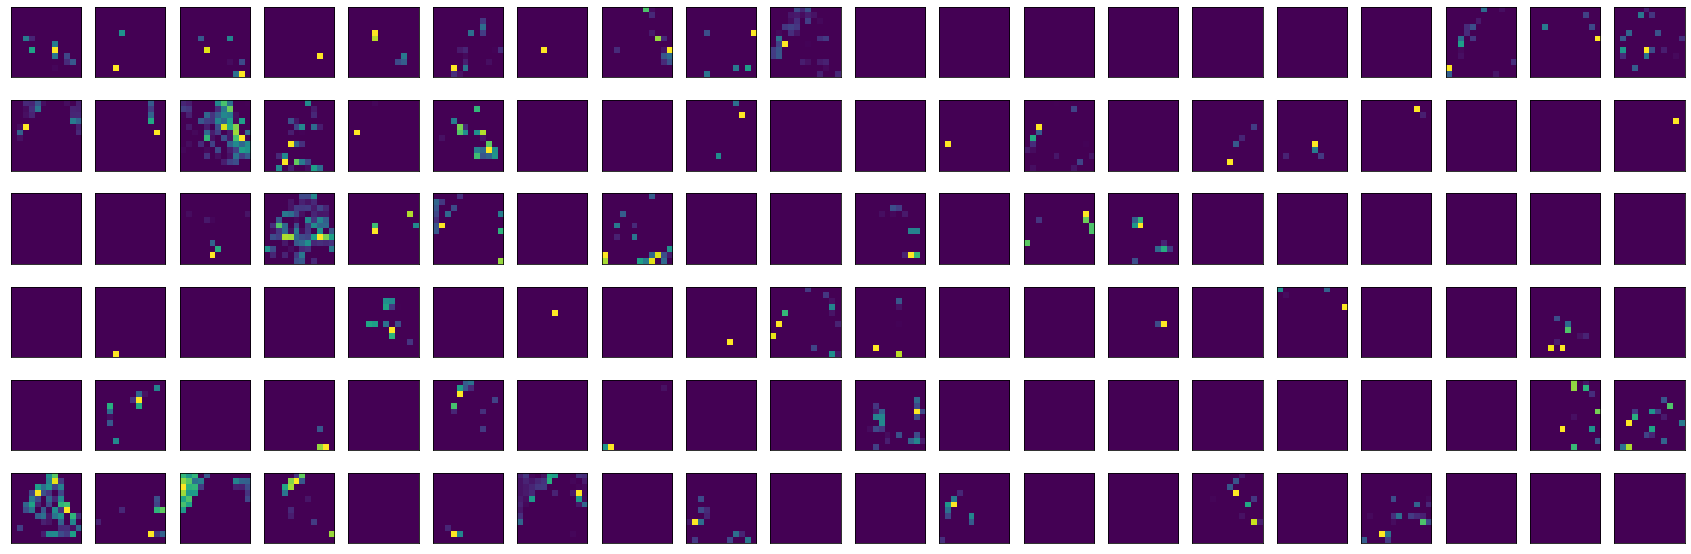

In [101]:
#features convolution8
first_layer_activation = activations[7]
print(first_layer_activation.shape)
# plt.matshow(first_layer_activation[0,:,:,31],cmap = 'viridis')


plt.figure();

fig, ax = plt.subplots(6, 20, subplot_kw=dict(xticks=[], yticks=[]),figsize=(30,10));

for i, axi in enumerate(ax.flat):
    # axi.set_title()
    # img = plt.imread(test_data_ext.filepaths[i])
    axi.imshow(first_layer_activation[0,:,:,i],cmap = 'viridis');